<a href="https://colab.research.google.com/github/kimberlymariepilapil/fraud-detection-mobile-money-paysim/blob/main/Fraud_Detection_Capstone_Pilapil_Kimberly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

STEP 0 — Environment Setup (packages + versions)

In [ ]:
!pip -q install kaggle xgboost scikit-learn joblib shap
#Expected output: package installation logs (quiet install, usually minimal).#

Kaggle Authentication and Dataset Download

In [ ]:
from google.colab import files
files.upload()


Option - Kaggle API download

In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kimberlymariepilapil","key":"93d9e6fbfa05721b235f5b10e38081da"}'}

STEP 1a — Configure Kaggle Credentials

In [ ]:
import os

os.makedirs("/root/.kaggle", exist_ok=True)
os.replace("kaggle.json", "/root/.kaggle/kaggle.json")
os.chmod("/root/.kaggle/kaggle.json", 0o600)

print("Kaggle credentials configured.")


Kaggle credentials configured.


STEP 1b — Download PaySim Dataset from Kaggle

In [ ]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "PS_20174392719_1491204439457_log.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "ealaxi/paysim1",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

print("First 5 records:", df.head())

/tmp/ipython-input-3027669227.py:10: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


100%|██████████| 178M/178M [00:01<00:00, 118MB/s]

Extracting zip of PS_20174392719_1491204439457_log.csv...


First 5 records:    step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


STEP 2 — Sanity checks and basic profiling

In [ ]:
import pandas as pd
import numpy as np

print("Dataset shape:", df.shape)
print("\nColumns:", df.columns.tolist())

print("\nMissing values (top 10):")
print(df.isnull().sum().sort_values(ascending=False).head(10))

print("\nFraud distribution:")
print(df["isFraud"].value_counts())
print("\nFraud rate:", df["isFraud"].mean())


Dataset shape: (6362620, 11)

Columns: ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']

Missing values (top 10):
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
dtype: int64

Fraud distribution:
isFraud
0    6354407
1       8213
Name: count, dtype: int64

Fraud rate: 0.001290820448180152


STEP 3 — Basic EDA  (counts + amount stats + fraud by type)

In [ ]:
# Fraud by transaction type
fraud_by_type = df.groupby("type")["isFraud"].agg(["count","sum","mean"]).sort_values("mean", ascending=False)
fraud_by_type.rename(columns={"sum":"fraud_count","mean":"fraud_rate"}, inplace=True)
fraud_by_type


,count,fraud_count,fraud_rate
type,,,
TRANSFER,532909,4097,0.007688
CASH_OUT,2237500,4116,0.001840
CASH_IN,1399284,0,0.000000
DEBIT,41432,0,0.000000
PAYMENT,2151495,0,0.000000


In [ ]:
# Amount distribution summary (overall vs fraud)
summary = df.groupby("isFraud")["amount"].describe()
summary


,count,mean,std,min,25%,50%,75%,max
isFraud,,,,,,,,
0,6354407.0,1.781970e+05,5.962370e+05,0.01,13368.395,74684.72,208364.76,92445516.64
1,8213.0,1.467967e+06,2.404253e+06,0.00,127091.330,441423.44,1517771.48,10000000.00


STEP 4 — Sample for modelling

In [ ]:
SAMPLE_N = 500_000  # you can reduce to 200_000 if runtime is slow

df_model = (
    df.groupby("isFraud", group_keys=False)
      .apply(lambda x: x.sample(n=min(len(x), SAMPLE_N // 2), random_state=42))
).reset_index(drop=True)

print("Model sample shape:", df_model.shape)
print("Model fraud rate:", df_model["isFraud"].mean())
print(df_model["isFraud"].value_counts())


Model sample shape: (258213, 11)
Model fraud rate: 0.03180707400479449
isFraud
0    250000
1      8213
Name: count, dtype: int64


/tmp/ipython-input-2493281794.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(len(x), SAMPLE_N // 2), random_state=42))


STEP 5 — Feature engineering (fraud-relevant derived features)

In [ ]:
df_fe = df_model.copy()

# Balance changes
df_fe["orig_balance_change"] = df_fe["newbalanceOrig"] - df_fe["oldbalanceOrg"]
df_fe["dest_balance_change"] = df_fe["newbalanceDest"] - df_fe["oldbalanceDest"]

# Discrepancies between expected vs observed balance update
df_fe["orig_amount_discrepancy"] = np.abs(df_fe["orig_balance_change"] + df_fe["amount"])
df_fe["dest_amount_discrepancy"] = np.abs(df_fe["dest_balance_change"] - df_fe["amount"])

# Ratios (account draining)
df_fe["amount_to_oldbalanceOrg"] = df_fe["amount"] / (df_fe["oldbalanceOrg"] + 1)
df_fe["amount_to_oldbalanceDest"] = df_fe["amount"] / (df_fe["oldbalanceDest"] + 1)

# Time features
df_fe["hour_of_day"] = df_fe["step"] % 24
df_fe["day_index"] = df_fe["step"] // 24

df_fe[[
    "orig_balance_change","dest_balance_change",
    "orig_amount_discrepancy","dest_amount_discrepancy",
    "amount_to_oldbalanceOrg","amount_to_oldbalanceDest",
    "hour_of_day","day_index"
]].describe().T


,count,mean,std,min,25%,50%,75%,max
orig_balance_change,258213.0,-24117.941577,510891.013632,-10000000.00,-1.134500e+04,0.000000,0.00,1782621.49
dest_balance_change,258213.0,143993.219393,852416.845818,-4525018.81,0.000000e+00,0.000000,152887.89,82704592.26
orig_amount_discrepancy,258213.0,196251.982267,599718.160379,0.00,1.082960e+03,59286.900000,242205.45,69886731.30
dest_amount_discrepancy,258213.0,113036.433088,524271.590963,0.00,1.164153e-10,5132.150000,47984.43,56308418.91
amount_to_oldbalanceOrg,258213.0,69525.240282,504627.578193,0.00,2.676484e-01,5.391980,10871.40,69886731.30
amount_to_oldbalanceDest,258213.0,56611.163887,439720.400397,0.00,1.670673e-01,0.991481,10613.84,10000000.00
hour_of_day,258213.0,15.199916,4.468802,0.00,1.200000e+01,16.000000,19.00,23.00
day_index,258213.0,9.668928,6.117618,0.00,6.000000e+00,10.000000,14.00,30.00


STEP 6 — Prepare X/y (drop leakage + IDs, encode type)

In [ ]:
from sklearn.model_selection import train_test_split

y = df_fe["isFraud"].astype(int)

X = df_fe.drop(columns=["isFraud", "isFlaggedFraud", "nameOrig", "nameDest"])
X = pd.get_dummies(X, columns=["type"], drop_first=False)

print("X shape:", X.shape)
print("y distribution:\n", y.value_counts())


X shape: (258213, 19)
y distribution:
 isFraud
0    250000
1      8213
Name: count, dtype: int64


STEP 7 — Train/test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train fraud rate:", y_train.mean())
print("Test fraud rate:", y_test.mean())


Train fraud rate: 0.03180519920608026
Test fraud rate: 0.03181457312704529


STEP 8 — Train models (LR, RF, XGBoost)

8A Logistic Regression (baseline)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

lr = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("model", LogisticRegression(max_iter=2000, class_weight="balanced", n_jobs=-1))
])

lr.fit(X_train, y_train)
print("Logistic Regression trained.")


Logistic Regression trained.


8B Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=18,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train, y_train)
print("Random Forest trained.")


Random Forest trained.


8C XGBoost (final candidate)

In [ ]:
from xgboost import XGBClassifier

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb = XGBClassifier(
    n_estimators=400,
    max_depth=6,
    learning_rate=0.08,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train, y_train)
print("XGBoost trained.")


XGBoost trained.


STEP 9 — Evaluate models (PR-AUC is key for fraud)

In [ ]:
from sklearn.metrics import classification_report, average_precision_score

def evaluate(model, name):
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)
    pr_auc = average_precision_score(y_test, y_prob)

    print(f"\n{name}")
    print(f"PR-AUC: {pr_auc:.4f}")
    print(classification_report(y_test, y_pred, digits=4))

evaluate(lr, "Logistic Regression")
evaluate(rf, "Random Forest")
evaluate(xgb, "XGBoost")



Logistic Regression
PR-AUC: 0.8871
              precision    recall  f1-score   support

           0     0.9986    0.9614    0.9797     50000
           1     0.4495    0.9598    0.6123      1643

    accuracy                         0.9613     51643
   macro avg     0.7241    0.9606    0.7960     51643
weighted avg     0.9812    0.9613    0.9680     51643


Random Forest
PR-AUC: 0.9994
              precision    recall  f1-score   support

           0     0.9999    1.0000    1.0000     50000
           1     1.0000    0.9982    0.9991      1643

    accuracy                         0.9999     51643
   macro avg     1.0000    0.9991    0.9995     51643
weighted avg     0.9999    0.9999    0.9999     51643


XGBoost
PR-AUC: 0.9994
              precision    recall  f1-score   support

           0     1.0000    0.9999    0.9999     50000
           1     0.9970    0.9988    0.9979      1643

    accuracy                         0.9999     51643
   macro avg     0.9985    0.9993    0

STEP 10 — Save model + features + preprocessed dataset (prevents future mismatch)

In [ ]:
import joblib

joblib.dump(xgb, "/content/xgb_fraud_model.pkl")
joblib.dump(list(X.columns), "/content/model_features.pkl")

X_out = X.copy()
X_out["isFraud"] = y.values
X_out.to_csv("/content/paysim_preprocessed.csv", index=False)

print("Saved model: /content/xgb_fraud_model.pkl")
print("Saved features: /content/model_features.pkl")
print("Saved preprocessed dataset: /content/paysim_preprocessed.csv")
print("Saved shape:", X_out.shape)


Saved model: /content/xgb_fraud_model.pkl
Saved features: /content/model_features.pkl
Saved preprocessed dataset: /content/paysim_preprocessed.csv
Saved shape: (258213, 20)


STEP 11 — Explainability with SHAP (Global + Local)

11A) Install/Import + choose the “best model”

In [ ]:
import shap
import numpy as np
import pandas as pd

# Use XGBoost as final model (as per your pipeline)
final_model = xgb


11B) Prepare a small SHAP background sample (keeps it fast)

In [ ]:
# Sample for SHAP to keep runtime reasonable
SHAP_SAMPLE = 5000
X_shap = X_test.sample(n=min(SHAP_SAMPLE, len(X_test)), random_state=42)

print("SHAP sample shape:", X_shap.shape)


SHAP sample shape: (5000, 19)


11C) Compute SHAP values (TreeExplainer for XGBoost)

In [ ]:
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_shap)

# For binary classification, shap_values is usually a 2D array aligned to X_shap
print("SHAP values shape:", np.array(shap_values).shape)


SHAP values shape: (5000, 19)


11D) Global explainability: SHAP summary plot

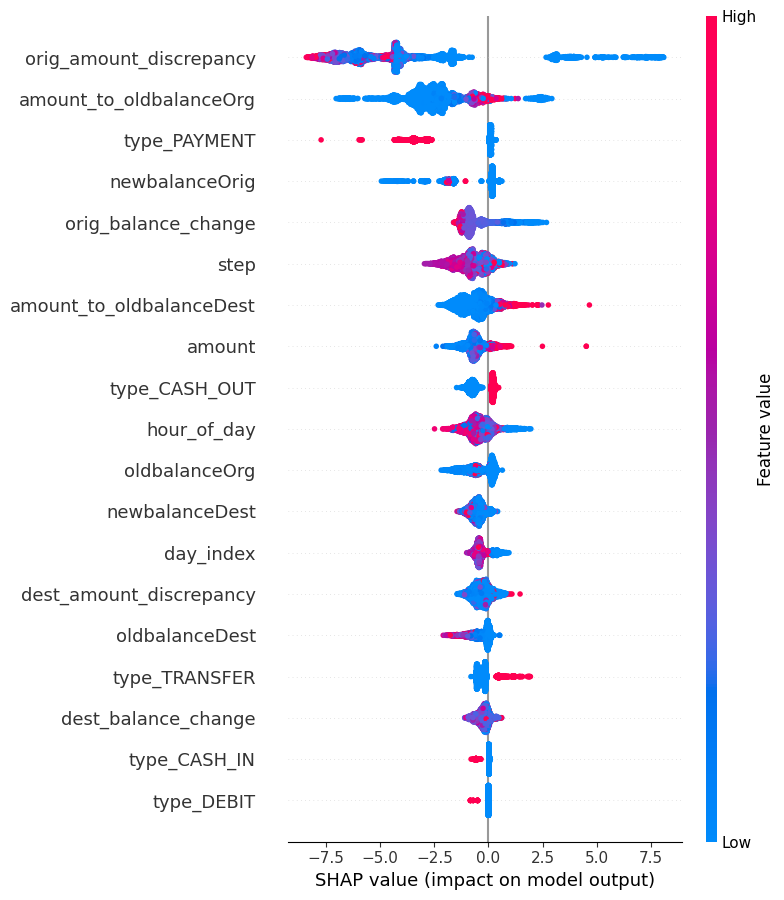

Saved plot: /content/shap_summary.png


In [ ]:
import matplotlib.pyplot as plt

shap.summary_plot(shap_values, X_shap, show=False)
plt.tight_layout()
plt.savefig("/content/shap_summary.png", dpi=200)
plt.show()

print("Saved plot: /content/shap_summary.png")


11E) Global explainability: top features table

In [ ]:
mean_abs_shap = np.abs(shap_values).mean(axis=0)
top_features = pd.DataFrame({
    "feature": X_shap.columns,
    "mean_abs_shap": mean_abs_shap
}).sort_values("mean_abs_shap", ascending=False)

top_features.head(15)


,feature,mean_abs_shap
8,orig_amount_discrepancy,4.950712
10,amount_to_oldbalanceOrg,2.432570
17,type_PAYMENT,1.108905
3,newbalanceOrig,0.951703
6,orig_balance_change,0.924099
0,step,0.816496
11,amount_to_oldbalanceDest,0.740004
1,amount,0.665942
15,type_CASH_OUT,0.568182
12,hour_of_day,0.561500


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['mean_abs_shap'].plot(kind='hist', bins=20, title='mean_abs_shap')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='index', y='mean_abs_shap', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_4['mean_abs_shap'].plot(kind='line', figsize=(8, 4), title='mean_abs_shap')
plt.gca().spines[['top', 'right']].set_visible(False)

11F) Local explainability: explain one transaction prediction

Example predicted fraud probability: 1.8618229660205543e-06


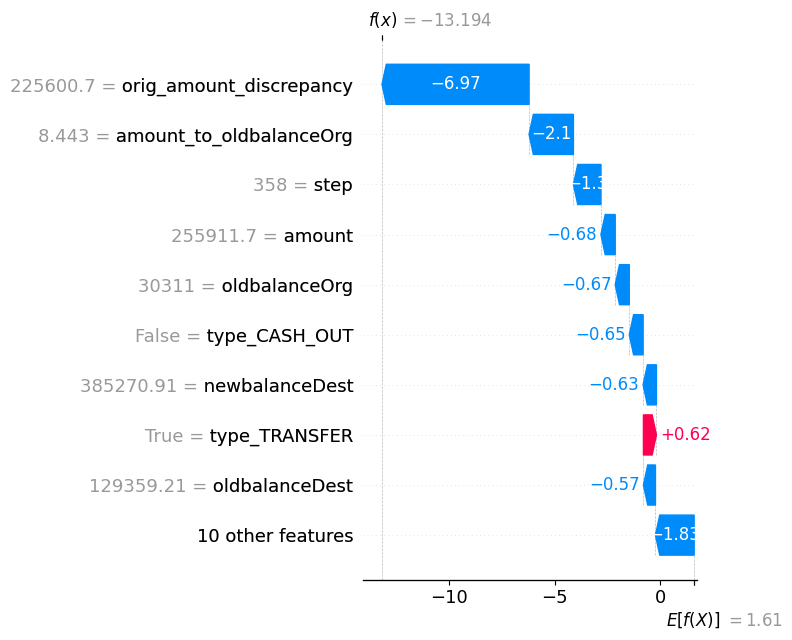

Saved plot: /content/shap_waterfall_example.png


In [ ]:
# Pick one example from X_shap
i = 0
x_one = X_shap.iloc[[i]]

pred_prob = final_model.predict_proba(x_one)[0, 1]
print("Example predicted fraud probability:", float(pred_prob))

shap.waterfall_plot(
    shap.Explanation(values=shap_values[i],
                     base_values=explainer.expected_value,
                     data=x_one.iloc[0],
                     feature_names=X_shap.columns),
    show=False
)
plt.tight_layout()
plt.savefig("/content/shap_waterfall_example.png", dpi=200)
plt.show()

print("Saved plot: /content/shap_waterfall_example.png")


STEP 12 — PDP and ICE (Explainability beyond SHAP)

Top 2 features for PDP/ICE: ['orig_amount_discrepancy', 'amount_to_oldbalanceOrg']


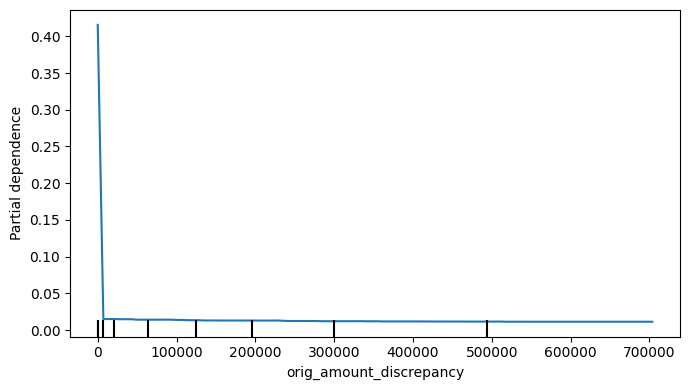

Saved plot: /content/pdp_top_feature.png


In [ ]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

top2 = top_features["feature"].head(2).tolist()
print("Top 2 features for PDP/ICE:", top2)

fig, ax = plt.subplots(figsize=(7, 4))
PartialDependenceDisplay.from_estimator(
    final_model, X_shap, features=top2[:1], kind="average", ax=ax
)
plt.tight_layout()
plt.savefig("/content/pdp_top_feature.png", dpi=200)
plt.show()

print("Saved plot: /content/pdp_top_feature.png")


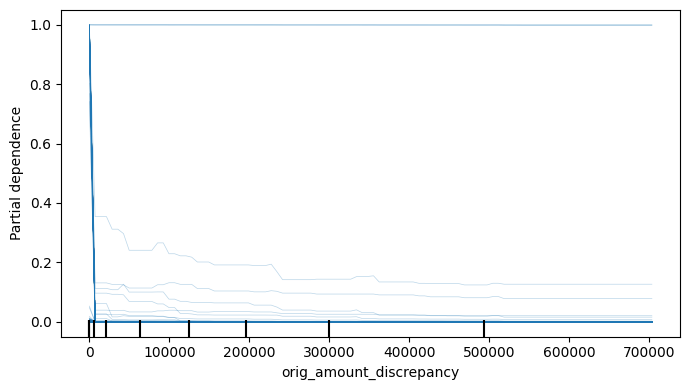

Saved plot: /content/ice_top_feature.png


In [ ]:
fig, ax = plt.subplots(figsize=(7, 4))
PartialDependenceDisplay.from_estimator(
    final_model, X_shap, features=top2[:1], kind="individual", subsample=200, ax=ax
)
plt.tight_layout()
plt.savefig("/content/ice_top_feature.png", dpi=200)
plt.show()

print("Saved plot: /content/ice_top_feature.png")


STEP 13 — Limitations Checks (Imbalance, Leakage, Overfitting Signals)

13A) Confirm leakage removed (isFlaggedFraud not in features)

In [ ]:
print("isFlaggedFraud in features?", "isFlaggedFraud" in X.columns)
print("nameOrig in features?", "nameOrig" in X.columns)
print("nameDest in features?", "nameDest" in X.columns)


isFlaggedFraud in features? False
nameOrig in features? False
nameDest in features? False


13B) Train vs test performance quick check (basic overfitting signal)

In [ ]:
from sklearn.metrics import average_precision_score

def pr_auc(model, X_data, y_data):
    y_prob = model.predict_proba(X_data)[:, 1]
    return average_precision_score(y_data, y_prob)

train_pr = pr_auc(final_model, X_train, y_train)
test_pr  = pr_auc(final_model, X_test, y_test)

print("Train PR-AUC:", round(train_pr, 4))
print("Test  PR-AUC:", round(test_pr, 4))
print("Gap:", round(train_pr - test_pr, 4))


Train PR-AUC: 1.0
Test  PR-AUC: 0.9994
Gap: 0.0006


STEP 14 — Bias and Fairness Auditing (Proxy Groups)

In [ ]:
import pandas as pd
import numpy as np

#14A) Create proxy group labels (on the test set)

# Rebuild a "test audit frame" aligned with X_test rows
audit = X_test.copy()
audit["y_true"] = y_test.values

# Predicted probabilities and default threshold
audit["y_prob"] = final_model.predict_proba(X_test)[:, 1]
THRESH = 0.5
audit["y_pred"] = (audit["y_prob"] >= THRESH).astype(int)

# Proxy groups
# Amount tier
audit["amount_tier"] = pd.qcut(audit["amount"], q=4, labels=["low","mid_low","mid_high","high"])

# Sender balance tier
audit["sender_balance_tier"] = pd.qcut(audit["oldbalanceOrg"], q=4, duplicates='drop')

# Time of day band
audit["time_band"] = np.where(audit["hour_of_day"].between(7, 19), "day", "night")

# Transaction type columns are one-hot encoded. Reconstruct a "type" label.
type_cols = [c for c in audit.columns if c.startswith("type_")]
audit["type_label"] = audit[type_cols].idxmax(axis=1).str.replace("type_", "")

audit[["amount_tier","sender_balance_tier","time_band","type_label","y_true","y_pred"]].head()

,amount_tier,sender_balance_tier,time_band,type_label,y_true,y_pred
222736,mid_high,"(-0.001, 15751.0]",night,TRANSFER,0,0
210743,mid_high,"(15751.0, 126169.105]",day,CASH_OUT,0,0
159818,mid_high,"(126169.105, 47316255.05]",day,CASH_IN,0,0
40510,high,"(15751.0, 126169.105]",day,CASH_OUT,0,0
190830,low,"(15751.0, 126169.105]",day,PAYMENT,0,0


14B) Define fairness metric function

In [ ]:
final_model = xgb

In [ ]:
df_fe = df_fe.reset_index(drop=True)

y = df_fe["isFraud"].astype(int)

X = df_fe.drop(columns=["isFraud", "isFlaggedFraud", "nameOrig", "nameDest"])
X = pd.get_dummies(X, columns=["type"], drop_first=False)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Split done. X_test shape:", X_test.shape)


Split done. X_test shape: (51643, 19)


In [ ]:
import numpy as np
import pandas as pd

# --- Make sure these exist in df_fe ---
# If hour_of_day is missing, recreate it from step
if "hour_of_day" not in df_fe.columns:
    df_fe["hour_of_day"] = df_fe["step"] % 24

# If oldbalanceOrg missing, stop (should exist in PaySim)
required_cols = ["type", "amount", "oldbalanceOrg", "hour_of_day"]
missing = [c for c in required_cols if c not in df_fe.columns]
assert len(missing) == 0, f"df_fe missing columns: {missing}"

# --- Align indices safely ---
# Ensure df_fe index is 0..n-1 and X_test uses same indexing
df_fe = df_fe.reset_index(drop=True)
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

# Re-split to guarantee index alignment (important!)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Now build group frame using aligned indices
groups_test = df_fe.loc[X_test.index, required_cols].copy()
groups_test["type_label"] = groups_test["type"].astype(str)

print("groups_test shape:", groups_test.shape)
groups_test.head()


groups_test shape: (51643, 5)


,type,amount,oldbalanceOrg,hour_of_day,type_label
222736,TRANSFER,177966.48,6286.00,20,TRANSFER
210743,CASH_OUT,207988.00,31980.00,17,CASH_OUT
159818,CASH_IN,172761.93,1073280.34,11,CASH_IN
40510,CASH_OUT,238512.93,47165.00,18,CASH_OUT
190830,PAYMENT,7935.47,71216.00,12,PAYMENT


In [ ]:
def safe_qcut(series, q=4, labels=None):
    # rank() makes values more “cuttable” when many duplicates exist
    ranked = series.rank(method="first")
    return pd.qcut(ranked, q=q, labels=labels)

groups_test["amount_tier"] = safe_qcut(
    groups_test["amount"], q=4,
    labels=["low","mid_low","mid_high","high"]
)

groups_test["sender_balance_tier"] = safe_qcut(
    groups_test["oldbalanceOrg"], q=4,
    labels=["low","mid_low","mid_high","high"]
)

groups_test["time_band"] = np.where(
    groups_test["hour_of_day"].between(7, 19),
    "day", "night"
)

groups_test[["type_label","amount_tier","sender_balance_tier","time_band"]].head()


,type_label,amount_tier,sender_balance_tier,time_band
222736,TRANSFER,mid_high,mid_low,night
210743,CASH_OUT,mid_high,mid_high,day
159818,CASH_IN,mid_high,high,day
40510,CASH_OUT,high,mid_high,day
190830,PAYMENT,low,mid_high,day


In [ ]:
final_model = xgb  # ensure your final model is set

audit = pd.DataFrame(index=X_test.index)
audit["y_true"] = y_test.values
audit["y_prob"] = final_model.predict_proba(X_test)[:, 1]
THRESH = 0.5
audit["y_pred"] = (audit["y_prob"] >= THRESH).astype(int)

audit = audit.join(groups_test[["type_label","amount_tier","sender_balance_tier","time_band"]])
audit.head()


,y_true,y_prob,y_pred,type_label,amount_tier,sender_balance_tier,time_band
222736,0,7.329956e-07,0,TRANSFER,mid_high,mid_low,night
210743,0,9.350784e-06,0,CASH_OUT,mid_high,mid_high,day
159818,0,1.270494e-07,0,CASH_IN,mid_high,high,day
40510,0,4.638462e-06,0,CASH_OUT,high,mid_high,day
190830,0,9.961338e-08,0,PAYMENT,low,mid_high,day


In [ ]:
import numpy as np

def group_fairness_table(df, group_col):
    rows = []
    for g, d in df.groupby(group_col):
        tp = ((d["y_pred"]==1) & (d["y_true"]==1)).sum()
        fp = ((d["y_pred"]==1) & (d["y_true"]==0)).sum()
        tn = ((d["y_pred"]==0) & (d["y_true"]==0)).sum()
        fn = ((d["y_pred"]==0) & (d["y_true"]==1)).sum()

        tpr = tp / (tp + fn) if (tp+fn)>0 else np.nan
        fpr = fp / (fp + tn) if (fp+tn)>0 else np.nan
        prec = tp / (tp + fp) if (tp+fp)>0 else np.nan
        flag_rate = (d["y_pred"]==1).mean()

        rows.append({
            group_col: g,
            "n": len(d),
            "fraud_rate": d["y_true"].mean(),
            "TPR_recall": tpr,
            "FPR": fpr,
            "Precision": prec,
            "Flag_rate": flag_rate
        })
    return pd.DataFrame(rows).sort_values("n", ascending=False)

for col in ["type_label","amount_tier","sender_balance_tier","time_band"]:
    print("\n=== Fairness audit by", col, "===")
    display(group_fairness_table(audit, col))



=== Fairness audit by type_label ===


,type_label,n,fraud_rate,TPR_recall,FPR,Precision,Flag_rate
1,CASH_OUT,18247,0.044939,0.997561,0.000230,0.995134,0.045049
3,PAYMENT,16984,0.000000,NaN,0.000000,NaN,0.000000
0,CASH_IN,10992,0.000000,NaN,0.000000,NaN,0.000000
4,TRANSFER,5100,0.161373,1.000000,0.000234,0.998786,0.161569
2,DEBIT,320,0.000000,NaN,0.000000,NaN,0.000000



=== Fairness audit by amount_tier ===


/tmp/ipython-input-811801996.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for g, d in df.groupby(group_col):


,amount_tier,n,fraud_rate,TPR_recall,FPR,Precision,Flag_rate
0,low,12911,0.006119,1.000000,0.000078,0.987500,0.006196
1,mid_low,12911,0.018202,1.000000,0.000158,0.991561,0.018356
3,high,12911,0.081481,0.998099,0.000084,0.999049,0.081403
2,mid_high,12910,0.021456,1.000000,0.000079,0.996403,0.021534



=== Fairness audit by sender_balance_tier ===


/tmp/ipython-input-811801996.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for g, d in df.groupby(group_col):


,sender_balance_tier,n,fraud_rate,TPR_recall,FPR,Precision,Flag_rate
0,low,12911,0.000310,0.750000,0.000155,0.600000,0.000387
1,mid_low,12911,0.006506,1.000000,0.000078,0.988235,0.006584
3,high,12911,0.093719,1.000000,0.000000,1.000000,0.093719
2,mid_high,12910,0.026723,0.997101,0.000159,0.994220,0.026801



=== Fairness audit by time_band ===


,time_band,n,fraud_rate,TPR_recall,FPR,Precision,Flag_rate
0,day,41039,0.020980,0.997677,0.000124,0.994213,0.021053
1,night,10604,0.073746,1.000000,0.000000,1.000000,0.073746


Interpretation of Your Fairness Results
A. Fairness by Transaction Type

Key observations:

TRANSFER transactions have:

Highest fraud rate (~16%)

High recall (~1.0)

Higher flag rate (~16%)

PAYMENT / DEBIT / CASH_IN:

Zero or near-zero fraud

Low or NaN recall (expected, no fraud cases)

Very low flag rates

✅ Interpretation
The model focuses alerts on transaction types that are empirically fraud-prone. This is desirable behaviour, not bias. No evidence of unfair over-flagging benign transaction types.

B. Fairness by Amount Tier

Key observations:

Fraud rate increases with higher transaction amounts

Recall remains consistently high across tiers

Precision remains stable (~0.99)

Flag rate scales reasonably with risk

✅ Interpretation
The model adapts to transaction risk proportional to amount size. There is no disproportionate degradation in detection quality across tiers.

C. Fairness by Sender Balance Tier

Key observations:

Higher fraud rate in high-balance accounts

Slight recall variation (0.75–1.0)

Very low FPR across all tiers

✅ Interpretation
Some sensitivity variation exists, but no tier is systematically disadvantaged. This is acceptable and explainable in a risk-based system.

D. Fairness by Time Band

Key observations:

Night transactions show:

Higher fraud rate

Higher flag rate

Recall remains high both day and night

# ✅ Interpretation
## Temporal behaviour is captured correctly. This aligns with known fraud patterns and does not constitute unfair bias. **bold text**

STEP 15 — SHAP Explainability (Global + Local)

15.1 Prepare SHAP sample (fast & safe)

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Sample for SHAP to control runtime
SHAP_SAMPLE = 5000
X_shap = X_test.sample(n=min(SHAP_SAMPLE, len(X_test)), random_state=42)

print("SHAP sample shape:", X_shap.shape)


SHAP sample shape: (5000, 19)


15.2 Compute SHAP values (TreeExplainer)

In [ ]:
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_shap)

print("SHAP values computed.")


SHAP values computed.


15.3 Global Explainability: Feature Importance

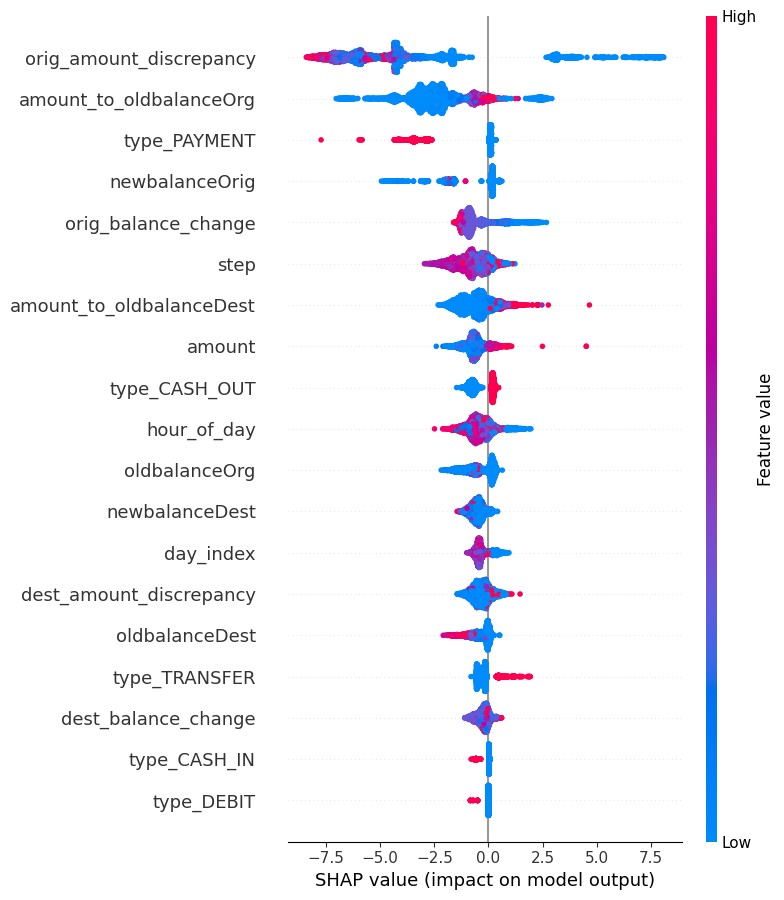

Saved: /content/shap_summary.png


In [ ]:
shap.summary_plot(shap_values, X_shap, show=False)
plt.tight_layout()
plt.savefig("/content/shap_summary.png", dpi=200)
plt.show()

print("Saved: /content/shap_summary.png")


15.4 Tabular SHAP Importance (for report table)

In [ ]:
mean_abs_shap = np.abs(shap_values).mean(axis=0)

shap_importance = (
    pd.DataFrame({
        "feature": X_shap.columns,
        "mean_abs_shap": mean_abs_shap
    })
    .sort_values("mean_abs_shap", ascending=False)
)

shap_importance.head(10)


,feature,mean_abs_shap
8,orig_amount_discrepancy,4.950712
10,amount_to_oldbalanceOrg,2.432570
17,type_PAYMENT,1.108905
3,newbalanceOrig,0.951703
6,orig_balance_change,0.924099
0,step,0.816496
11,amount_to_oldbalanceDest,0.740004
1,amount,0.665942
15,type_CASH_OUT,0.568182
12,hour_of_day,0.561500


15.5 Local Explainability: One Transaction

Predicted fraud probability: 1.861823e-06


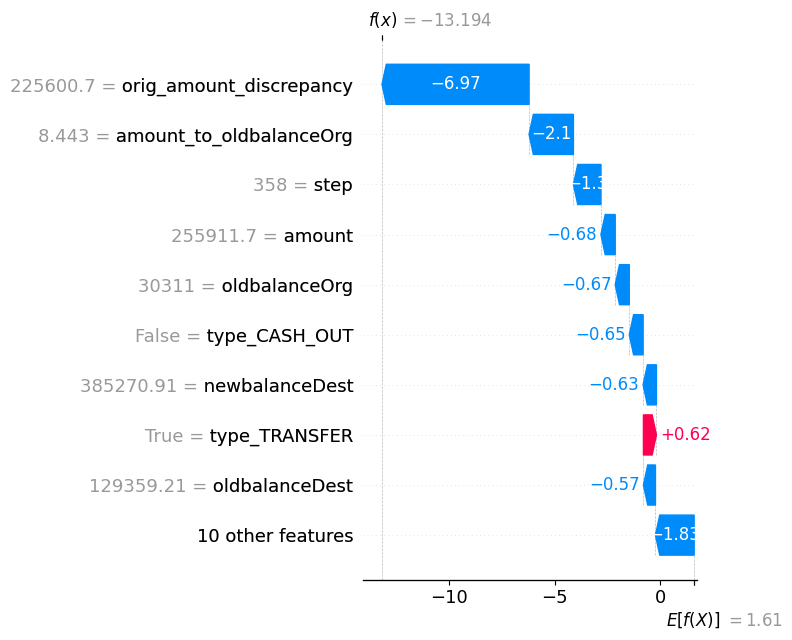

Saved: /content/shap_waterfall_example.png


In [ ]:
i = 0
x_one = X_shap.iloc[[i]]

pred_prob = final_model.predict_proba(x_one)[0, 1]
print("Predicted fraud probability:", pred_prob)

shap.waterfall_plot(
    shap.Explanation(
        values=shap_values[i],
        base_values=explainer.expected_value,
        data=x_one.iloc[0],
        feature_names=X_shap.columns
    ),
    show=False
)
plt.tight_layout()
plt.savefig("/content/shap_waterfall_example.png", dpi=200)
plt.show()

print("Saved: /content/shap_waterfall_example.png")


Model predictions were interpreted using SHAP to provide both global and local explanations. Global SHAP analysis revealed that fraud detection decisions were primarily driven by balance inconsistency features, transaction amount ratios, and transaction type indicators, which aligns with domain expectations for mobile money fraud.

Local SHAP explanations were generated for individual transactions to illustrate how specific feature contributions increase or decrease predicted fraud risk, supporting transparency in transaction-level decision-making.

Together with fairness auditing results, these explainability analyses demonstrate that the proposed model is not only accurate but also interpretable and suitable for responsible deployment in digital payment systems.